In [1]:
import pandas as pd
import xarray as xr
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from misc_useful_funcs import multiple_conditions_index_finder
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
# Open saved pre-processed IMERG and TC-RADAR files. Make sure they are created to the correct settings in the other notebooks.

In [3]:
# Open IMERG Data

vmax_arr_pd = pd.read_csv('/Users/acheung/data/Composite_Data/vmax_arr_arrs.csv',index_col=0)
vmax_arr_pd.columns = vmax_arr_pd.columns.astype(float)
full_info_pd = pd.read_csv('/Users/acheung/data/Composite_Data/Composite_info.csv',index_col=0)
all_last_slices_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/imerg_composites.nc')
all_last_slices_xr = all_last_slices_xr['__xarray_dataarray_variable__']

all_cylindrical_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/cylindrical_composite.nc')
all_cylindrical_xr = all_cylindrical_xr['__xarray_dataarray_variable__']

dtl_toggle = True

if dtl_toggle == True:
    full_info_pd = full_info_pd.where(full_info_pd['DTL'] >= 50).dropna() # Dropped storms less than 50 km away from land

# Open TC-RADAR Data

rotated_images_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/TC_RADAR_Rotated_recentered_reflectivityswath.nc'
                                   )['__xarray_dataarray_variable__']

swath_boolean = True

if swath_boolean == True:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_1997_2019_xy_rel_swath_ships.nc?download=1',
                     '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_2020_2022_xy_rel_swath_ships.nc?download=1']   
else:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']


tc_radar_data_pre = xr.open_mfdataset(nc_file_paths,combine='nested',concat_dim='num_cases')
tc_radar_data_pre['num_cases'] = range(0,len(tc_radar_data_pre['num_cases']))

In [4]:
# Cases that exist in both datasets
result = multiple_conditions_index_finder([rotated_images_xr['num_cases'].values,
                                          all_last_slices_xr['case'].values])
post_imerg = all_cylindrical_xr.sel(case=result) # IMERG
post_tc_radar_images = rotated_images_xr.sel(num_cases=result) # TC-RADAR
post_tc_radar_not_processed = tc_radar_data_pre.sel(num_cases=result)

In [61]:
lat_thresh = 25
subtropical_lat_cases = post_tc_radar_not_processed['num_cases'].where(abs(post_tc_radar_not_processed['lat_ships'].sel(
    num_ships_times=0)) >=lat_thresh).dropna('num_cases')

tropical_lat_cases = post_tc_radar_not_processed['num_cases'].where(abs(post_tc_radar_not_processed['lat_ships'].sel(
    num_ships_times=0)) <lat_thresh).dropna('num_cases')


weak_shear_cases = post_tc_radar_not_processed['num_cases'].where(post_tc_radar_not_processed['shrd_ships'].sel(
    num_ships_times=0) <=15).dropna('num_cases')


moderate_strong_shear_cases = post_tc_radar_not_processed['num_cases'].where(post_tc_radar_not_processed['shrd_ships'].sel(
    num_ships_times=0) >15).dropna('num_cases')

weak_storm_cases = post_tc_radar_not_processed['num_cases'].where(post_tc_radar_not_processed['vmax_ships'].sel(
    num_ships_times=0)<= 65).dropna('num_cases')

tropical_result = np.sort(multiple_conditions_index_finder([tropical_lat_cases.values,weak_storm_cases.values]))
subtropical_result = np.sort(multiple_conditions_index_finder([subtropical_lat_cases.values,weak_storm_cases.values]))


# Calculate mean shear of both groups

tropical_mean_shear = np.round(float(post_tc_radar_not_processed['shrd_ships'].sel(
    num_cases=tropical_result,num_ships_times=0).mean()),2) # kt

subtropical_mean_shear = np.round(float(post_tc_radar_not_processed['shrd_ships'].sel(
    num_cases=subtropical_result,num_ships_times=0).mean()),2) # kt

# Calculate mean intensity of both groups

tropical_mean_vmax = np.round(float(post_tc_radar_not_processed['vmax_ships'].sel(
    num_cases=tropical_result,num_ships_times=0).mean()),2) # kt

subtropical_mean_vmax = np.round(float(post_tc_radar_not_processed['vmax_ships'].sel(
    num_cases=subtropical_result,num_ships_times=0).mean()),2) # kt

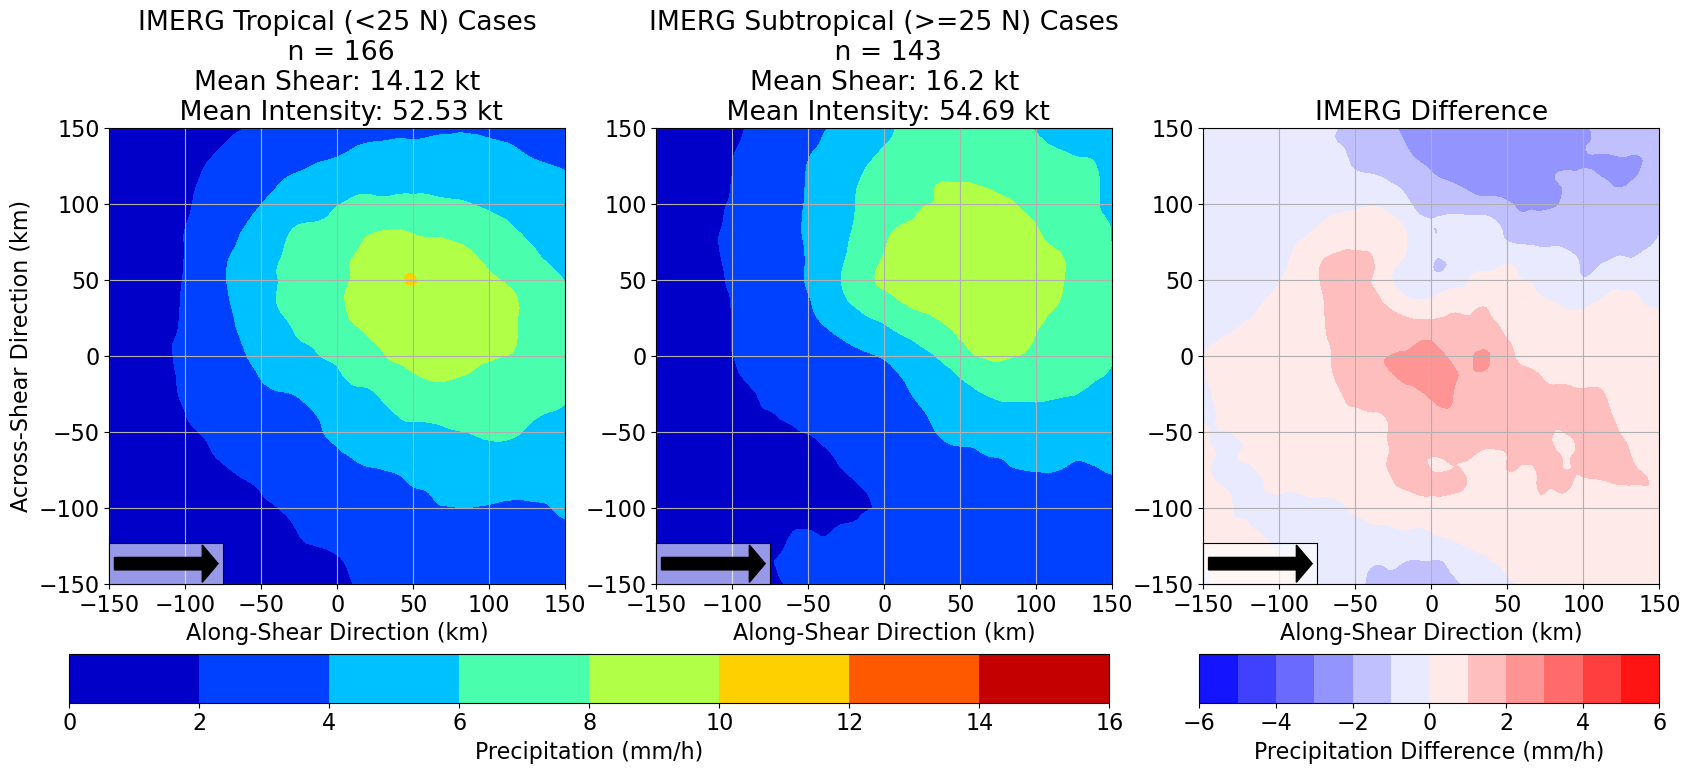

In [62]:
fig = plt.figure(figsize=(20, 7)) 
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
cax_1 = plt.axes([0.105, 0, 0.52, 0.07])

p1 = ax.contourf(all_last_slices_xr['x'],all_last_slices_xr['y'],
                 all_last_slices_xr.sel(case=tropical_result).mean('case'),
                 levels=np.arange(0,16.1,2),cmap='jet')
ax.grid()
plt.colorbar(p1,label='Precipitation (mm/h)',cax=cax_1,orientation='horizontal')
ax.set_title('IMERG Tropical (<'+str(lat_thresh)+ ' N) Cases\n n = ' + str(len(
    all_last_slices_xr.sel(case=tropical_result))) + '\nMean Shear: ' + str(tropical_mean_shear
                                                                           ) + ' kt\n Mean Intensity: ' +str(tropical_mean_vmax) + ' kt')
ax.set_ylabel('Across-Shear Direction (km)')
ax.set_xlabel('Along-Shear Direction (km)')
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# CHECK IF THIS IS CORRECT FOR EACH TIME CODE IS RAN!!!
p2 = ax2.contourf(all_last_slices_xr['x'],all_last_slices_xr['y'],
                  all_last_slices_xr.sel(case=subtropical_result).mean('case'),
                  levels=np.arange(0,16.1,2),cmap='jet')
ax2.set_xlabel('Along-Shear Direction (km)')
ax2.grid()
ax2.set_title('IMERG Subtropical (>='+str(lat_thresh)+ ' N) Cases\n n = ' + str(len(
    all_last_slices_xr.sel(case=subtropical_result))) + '\nMean Shear: ' + str(subtropical_mean_shear
                                                                              ) + ' kt\n Mean Intensity: ' +str(subtropical_mean_vmax) + ' kt')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax_2 = plt.axes([0.67, 0, 0.23, 0.07])
p3 = ax3.contourf(all_last_slices_xr['x'],all_last_slices_xr['y'],
                  all_last_slices_xr.sel(case=tropical_result).mean('case')
             - all_last_slices_xr.sel(case=subtropical_result).mean('case'),
             levels=np.arange(-6,6.1,1),cmap='bwr')
ax3.grid()
ax3.set_xlabel('Along-Shear Direction (km)')
ax3.set_title('IMERG Difference')
plt.colorbar(p3,label='Precipitation Difference (mm/h)',cax=cax_2,orientation='horizontal')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

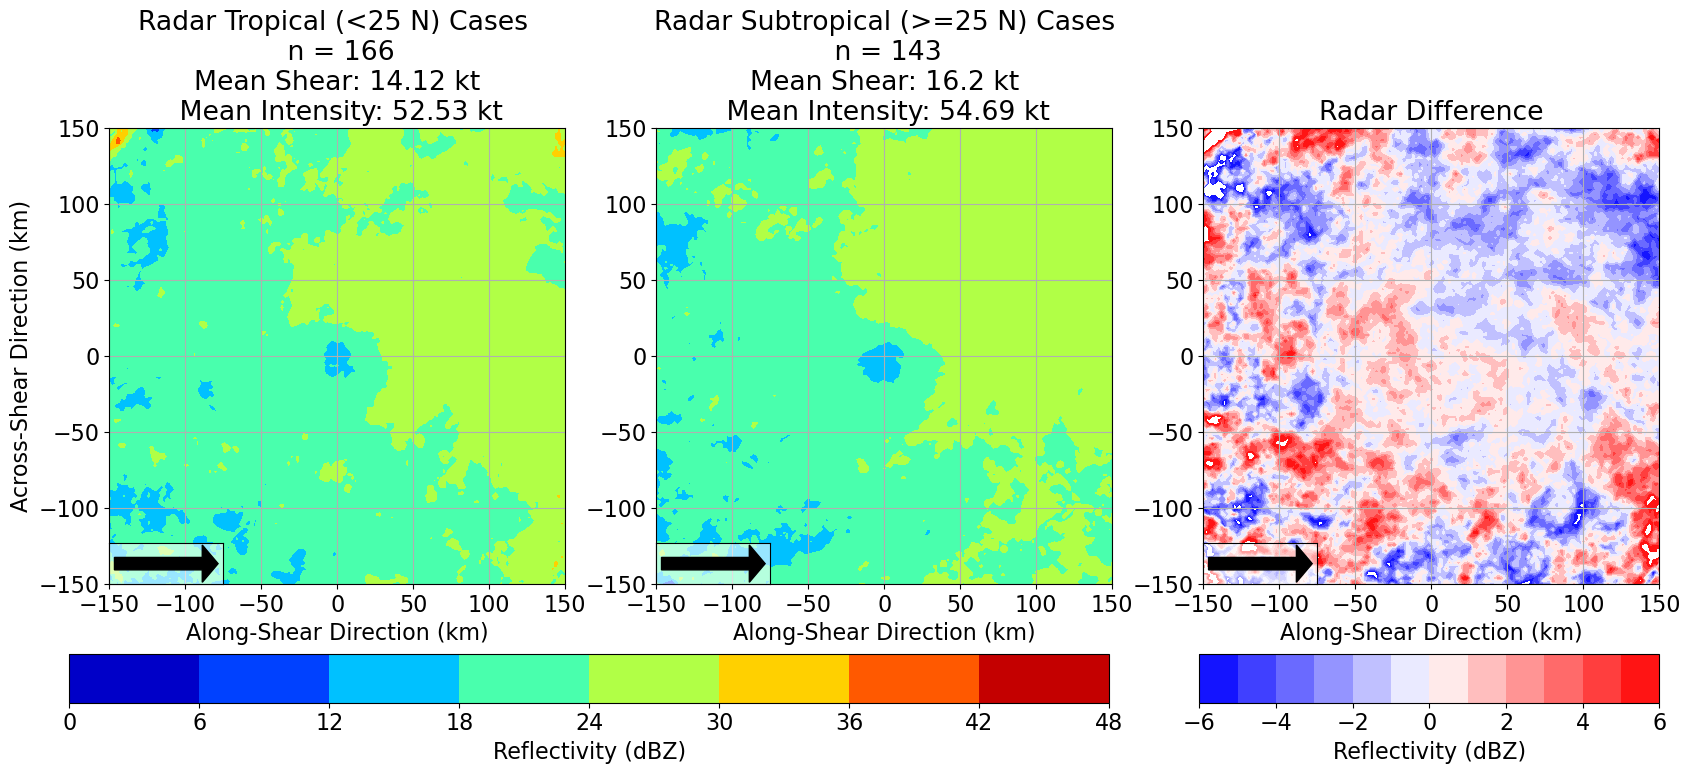

In [63]:
fig = plt.figure(figsize=(20, 7)) 
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
cax_1 = plt.axes([0.105, 0, 0.52, 0.07])

p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=tropical_result).mean('num_cases'),
                 levels=np.arange(0,48.1,6),cmap='jet')
ax.grid()
plt.colorbar(p1,label='Reflectivity (dBZ)',cax=cax_1,orientation='horizontal')
ax.set_title('Radar Tropical (<'+str(lat_thresh)+ ' N) Cases \n n = ' + str(len(
    rotated_images_xr.sel(num_cases=tropical_result))) + '\nMean Shear: ' + str(tropical_mean_shear) + ' kt\n Mean Intensity: ' +str(tropical_mean_vmax) + ' kt')
ax.set_ylabel('Across-Shear Direction (km)')
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
# CHECK IF THIS IS CORRECT FOR EACH TIME CODE IS RAN!!!
p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                  rotated_images_xr.sel(num_cases=subtropical_result).mean('num_cases'),
                  levels=np.arange(0,48.1,6),cmap='jet')
ax2.set_xlabel('Along-Shear Direction (km)')
ax2.grid()
ax2.set_title('Radar Subtropical (>='+str(lat_thresh)+ ' N) Cases\n n = ' + str(len(
    rotated_images_xr.sel(num_cases=subtropical_result))) + '\nMean Shear: ' + str(subtropical_mean_shear) + ' kt\n Mean Intensity: ' +str(subtropical_mean_vmax) + ' kt')
ax2.set_ylim(-150,150)
ax2.set_xlim(-150,150)

cax_2 = plt.axes([0.67, 0, 0.23, 0.07])

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                  rotated_images_xr.sel(num_cases=tropical_result).mean('num_cases')
             - rotated_images_xr.sel(num_cases=subtropical_result).mean('num_cases'),
             levels=np.arange(-6,6.1,1),cmap='bwr')
ax3.grid()
ax3.set_xlabel('Along-Shear Direction (km)')
ax3.set_title('Radar Difference')
ax3.set_xlim(-150,150)
ax3.set_ylim(-150,150)
plt.colorbar(p3,label='Reflectivity (dBZ)',cax=cax_2,orientation='horizontal')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)